# Dynamics

This file contains the functions for gravity between the masses and their motion.

https://levelup.gitconnected.com/the-two-body-problem-in-python-6bbe4a0b2f88


https://rjallain.medium.com/calculating-stable-circular-orbits-for-binary-stars-8b7fb8b081a1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import time
import math
import matplotlib as mp
import scipy as sp
import pylab as py
import os
import matplotlib.animation as animation

from scipy.integrate import odeint

plt.rcParams['axes.grid'] = True
plt.style.use('dark_background')

In [2]:
G = 6.67259e-20  # (km**3/kg/s**2)

def grav_force(mass_1, mass_2, r):
    """
    provides the force as a (x,y,z) array 
    must be given two masses and a (x,y,z) distance array
    """
    return r*(G*mass_1*mass_2)/(np.linalg.norm(r)**3)

def get_r(pos1, pos2):
    """
    provides the (x,y,z) distance array
    requires pos1 and pos2 to be (x,y,z) arrays
    """
    r_vec = np.array([pos1[0]-pos2[0], pos1[1]-pos2[1], pos1[2]-pos2[2]])
    return r_vec

def leapfrogintegrate(acc1, acc2, pos1, pos2, vel1, vel2, mass1, mass2):
    """
    pos1 = [x,y,z] array
    pos2 = [x,y,z] array
    vel1 = [x,y,z] array
    vel2 = [x,y,z] array
    
    does leapfrog integration and returns position and velocity values 
    """
    N = 100
    dt = 0.1
    
    # Create empty arrays 
    x1 = np.zeros(N)
    y1 = np.zeros(N)
    z1 = np.zeros(N)
    x2 = np.zeros(N)
    y2 = np.zeros(N)
    z2 = np.zeros(N)
    vx1 = np.zeros(N)
    vy1 = np.zeros(N)
    vz1 = np.zeros(N)
    vx2 = np.zeros(N)
    vy2 = np.zeros(N)
    vz2 = np.zeros(N)
    
    # initialize 

    
    for index in range(N-1):
        # set initial step 
        if index == 0:
            x1[index] = pos1[0]
            x2[index] = pos2[0]
            y1[index] = pos1[1]
            y2[index] = pos2[1]
            z1[index] = pos1[2]
            z2[index] = pos2[2]
            vx1[index] = vel1[0]
            vx2[index] = vel2[0]
            vy1[index] = vel1[1]
            vy2[index] = vel2[1]
            vz1[index] = vel1[2]
            vz2[index] = vel2[2]
        # integrate 
        else:
            r = get_r([x1[index-1],y1[index-1],z1[index-1]], [x2[index-1],y2[index-1],z2[index-1]])
            F = grav_force(mass1, mass2, r)
            # sets next velocity. 
            # uses the particle's acceleration, last jump, and grav force
            vx1[index] = vx1[index-1]+dt*(acc1+F[0]/mass1)
            vy1[index] = vy1[index-1]+dt*(acc1+F[1]/mass1)
            vz1[index] = vz1[index-1]+dt*(acc1+F[2]/mass1)
            vx2[index] = vx2[index-1]+dt*(acc2-F[0]/mass2)
            vy2[index] = vy2[index-1]+dt*(acc2-F[1]/mass2)
            vz2[index] = vz2[index-1]+dt*(acc2-F[2]/mass2)
            # sets next position. 
            # uses the last jump and next velocity 
            x1[index] = x1[index-1]+dt*vx1[index]
            x2[index] = x2[index-1]+dt*vx2[index]
            y1[index] = y1[index-1]+dt*vy1[index]
            y2[index] = y2[index-1]+dt*vy2[index]
            z1[index] = z1[index-1]+dt*vz1[index]
            z2[index] = z2[index-1]+dt*vz2[index]
    
    return x1,x2,y1,y2,z1,z2,vx1,vx2,vy1,vy2,vz1,vz2

In [3]:
def two_body_eqm(_y, _t, _G, _m1, _m2):
    """
    differential equations of motion describing the two-body-problem
    _t: discrete time step value
    _y: state vector
    """
    # magnitude of position vector from r1 to r2
    r_mag = np.linalg.norm(_y[3:6] - _y[:3])
    c0 = _y[6:12]
    c1 = _G * _m2 * ((_y[3:6] - _y[:3]) / np.power(r_mag, 3))
    c2 = _G * _m1 * ((_y[:3] - _y[3:6]) / np.power(r_mag, 3))
    return np.concatenate((c0, c1, c2))


# ==============================================================
# simulation harness


# time array
time = np.arange(0, 480, 0.5)

# body m1 initial conditions
m1 = 1e26  # mass (kg)
r10 = np.array([0, 0, 0])  # initial position (km)
v10 = np.array([10, 20, 30])  # initial velocity (km/s)

# body m2 initial conditions
m2 = 1e26  # mass (kg)
r20 = np.array([3000, 0, 0])  # initial position (km)
v20 = np.array([0, 40, 0])  # initial velocity (km/s)

# [X1 (0), Y1 (1), Z1 (2), X2 (3), Y2 (4), Z2 (5), VX1 (6), VY1 (7), VZ1 (8), VX2 (9), VY2 (10), VZ2 (11)]
y0 = np.concatenate((r10, r20, v10, v20))

# ==============================================================
# propagate state

# simulation results
state_history = []

y = odeint(two_body_eqm, y0, time, args=(G, m1, m2))
x1,x2,y1,y2,z1,z2,vx1,vx2,vy1,vy2,vz1,vz2 = leapfrogintegrate(0,0, r10, r20, v10, v20, m1, m2)

for yk in y:
    # extract inertial positions of body 1 and body 2
    r1 = yk[:3]
    r2 = yk[3:6]

    # determine position of centre of mass
    rg = ((m1 * r1) + (m2 * r2)) / (m1 + m2)

    # position vector from m1 to m2
    r12 = r2 - r1

    # position vector from m1 to g
    r1g = rg - r1

    # position vector from g to m1
    rg1 = r1 - rg

    # position vector from g to m2
    rg2 = r2 - rg

    # save state history (yk = 0-11, rg = 12-14, r12=15-17, ...)
    state_history.append(np.concatenate((yk, rg, r12, r1g, rg1, rg2), axis=None))

# convert list to numpy array
state_history = np.array(state_history)

## comparison 

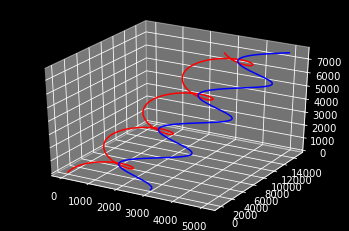

In [4]:
# odeint integration 
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(y[0:,0], y[0:,1], y[0:,2], c='red')
ax.plot(y[0:,3], y[0:,4], y[0:,5], c='blue')

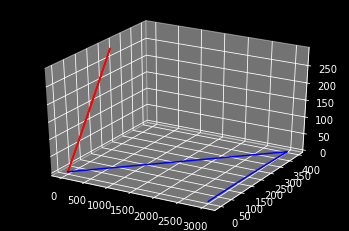

In [5]:
# leapfrog integration 
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(x1, y1, z1, c='red')
ax.plot(x2, y2, z2, c='blue')